In [196]:
%load_ext autoreload
%autoreload all

import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from gem.minifrance_tif_data import MiniFranceTIFData

sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

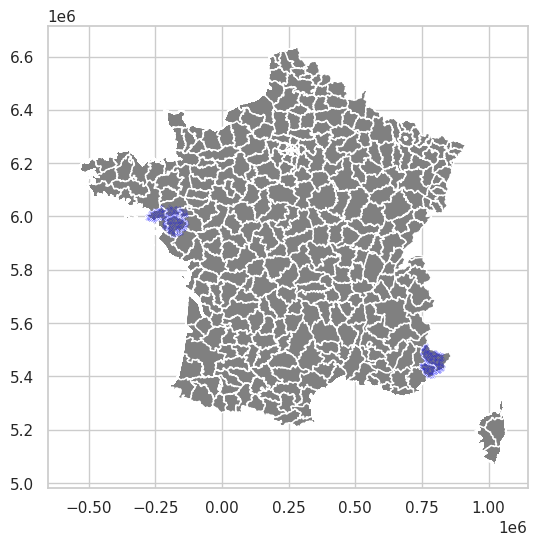

In [197]:
shp_path = "/GEM/files/france_shape/gy606rg8152.shp"
data_dir = "/GEM/data/labeled_train"

france_geo = gpd.read_file(shp_path)
minifrance_data = MiniFranceTIFData(data_dir)
coords_geo = minifrance_data.read_geodata()

france_geo.to_crs(coords_geo.crs, inplace=True)
base = france_geo.plot(color='gray', edgecolor='white')
coords_geo.plot(ax=base, marker='o', color='blue', markersize=0.01)

In [198]:
france_geo.head()

,id_0,iso,name_0,id_1,name_1,id_2,name_2,id_3,name_3,ccn_3,cca_3,type_3,engtype_3,nl_name_3,varname_3,geometry
0,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,1.0,Haguenau,0.0,NaN,Arrondissement,Districts,NaN,NaN,"POLYGON ((857540.757 6263979.952, 859063.924 6..."
1,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,2.0,Molsheim,0.0,NaN,Arrondissement,Districts,NaN,NaN,"POLYGON ((814557.137 6214802.680, 815679.540 6..."
2,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,3.0,Sélestat-Erstein,0.0,NaN,Arrondissement,Districts,NaN,NaN,"MULTIPOLYGON (((856665.659 6186677.636, 856632..."
3,79.0,FRA,France,1.0,Alsace,2.0,Haut-Rhin,13.0,Thann,0.0,NaN,Arrondissement,Districts,NaN,NaN,"POLYGON ((777181.394 6108422.513, 777364.896 6..."
4,79.0,FRA,France,1.0,Alsace,1.0,Bas-Rhin,4.0,Saverne,0.0,NaN,Arrondissement,Districts,NaN,NaN,"POLYGON ((792044.734 6286847.704, 791849.660 6..."


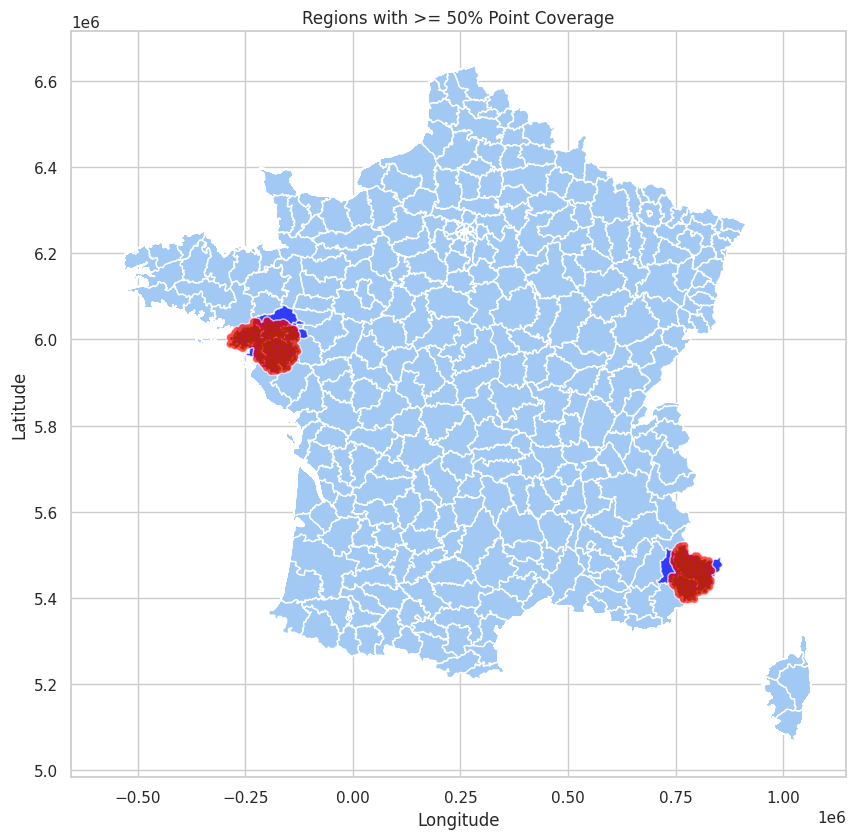

In [199]:
points = coords_geo.buffer(10000)

# Create a spatial index for the point GeoDataFrame for improved performance
coords_geo_sindex = coords_geo.sindex

# Initialize an empty list to store intersecting polygons
intersecting_polygons = []
point_coverage_geo = gpd.GeoSeries(points.unary_union, crs=points.crs)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Iterate through the polygons and check for intersection with points
for index, polygon in france_geo.iterrows():
    if point_coverage_geo.intersects(polygon.geometry).any():
        intersection = point_coverage_geo.intersection(polygon['geometry'])
        point_coverage = intersection.geometry.area.sum()
        intersecting_polygons.append({'geometry': polygon['geometry'], 'point_coverage': point_coverage})

# Create a new GeoDataFrame from the intersecting polygons
intersecting_gdf = gpd.GeoDataFrame(intersecting_polygons)
intersecting_gdf.set_crs(france_geo.crs, inplace=True)

# Calculate the total area of each polygon
intersecting_gdf['polygon_area'] = intersecting_gdf.geometry.area

# Calculate the percentage of point coverage for each polygon
intersecting_gdf['point_coverage_percentage'] = (intersecting_gdf['point_coverage'] / intersecting_gdf['polygon_area']) * 100

# Filter polygons with point coverage
populated_polygons = intersecting_gdf[intersecting_gdf['point_coverage_percentage'] >= 40]

# Plot the populated polygons
france_geo.plot(ax=ax, alpha=1)
populated_polygons.plot(ax=ax, color='blue', alpha=0.7)
coords_geo.plot(ax=ax, color='green', alpha=0.7, markersize=1)
point_coverage_geo.plot(ax=ax, color='red', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Regions with >= 50% Point Coverage')

# Set aspect ratio to 'equal' explicitly

plt.show()